# Compute Demo: Use Rooki to access CMIP6 data

## Overview

[Rooki](https://github.com/roocs/rooki) is a Python client to interact with [Rook](https://github.com/roocs/rook) data subsetting service for climate model data. This service is used in the backend by the [European Copernicus Climate Data Store](https://cds.climate.copernicus.eu) to access the CMIP6 data pool. The Rook service is deployed for load-balancing at IPSL (Paris) and DKRZ (Hamburg). The CMIP6 data pool is shared with ESGF. The provided CMIP6 subset for Copernicus is synchronized at both sites. 

*Rook* provides operators for *subsetting*, *averaging* and *regridding* to retrieve a subset of the CMIP6 data pool. These operators are implemented by the [clisops](https://github.com/roocs/clisops) Python libray and are based on [xarray](https://pypi.org/project/xarray/). The *clisops* library is developed by Ouranos (Canada), CEDA (UK) and DKRZ (Germany). 

The operators can be called remotly using the [OGC Web Processing Service](https://ogcapi.ogc.org/processes/) (WPS) standard.

![rook 4 cds](https://github.com/atmodatcode/tgif_copernicus/raw/main/media/rook.png)

**ROOK**: **R**emote **O**perations **O**n **K**limadaten

* Rook: https://github.com/roocs/rook
* Rooki: https://github.com/roocs/rooki
* Clisops: https://github.com/roocs/clisops
* Rook Presentation: https://github.com/cehbrecht/talk-rook-status-kickoff-meeting-2022/blob/main/Rook_C3S2_380_2022-02-11.pdf

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| [Knowing OGC services](https://ogcapi.ogc.org/processes/) | Helpful | Understanding of the service interfaces |


- **Time to learn**: 15 minutes

## Init Rooki

In [1]:
import os
os.environ['ROOK_URL'] = 'http://rook.dkrz.de/wps'

from rooki import rooki

## Retrieve subset of CMIP6 data

The CMIP6 dataset is identified by a dataset-id. An intake catalog as available to lookup the available datasets:

https://nbviewer.org/github/roocs/rooki/blob/master/notebooks/demo/demo-intake-catalog.ipynb

In [2]:
resp = rooki.subset(
    collection='c3s-cmip6.CMIP.MPI-M.MPI-ESM1-2-HR.historical.r1i1p1f1.Amon.tas.gn.v20190710',
    time='2000-01-01/2000-01-31',
    area='-30,-40,70,80',
)
resp.ok

True

### Open Dataset with xarray

In [3]:
ds = resp.datasets()[0]
ds

<xarray.Dataset> Size: 61kB
Dimensions:    (time: 1, bnds: 2, lat: 129, lon: 107)
Coordinates:
  * time       (time) datetime64[ns] 8B 2000-01-16T12:00:00
  * lat        (lat) float64 1kB -39.74 -38.81 -37.87 ... 78.08 79.01 79.95
  * lon        (lon) float64 856B -30.0 -29.06 -28.12 ... 67.5 68.44 69.38
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 16B ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 2kB ...
    tas        (time, lat, lon) float32 55kB ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/af75dd9f-d9c2-4e0e-a294-2bb0d5b740cf

### Plot CMIP6 Dataset

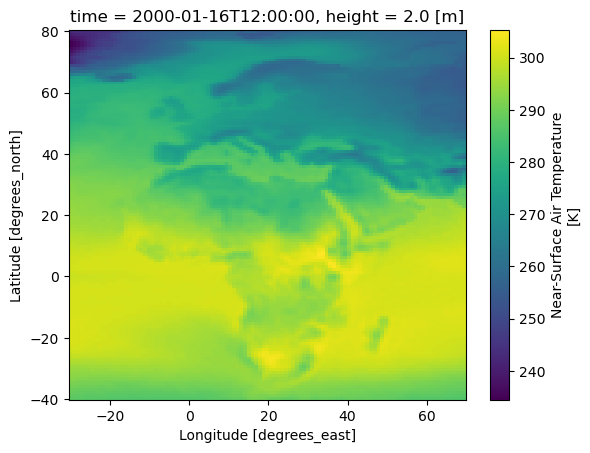

In [4]:
ds.tas.isel(time=0).plot()

### Show Provenance

A provenance document is generated remotely to document the operation steps.
The provenance uses the [W3C PROV](https://www.w3.org/TR/prov-overview/Overview.html) standard.

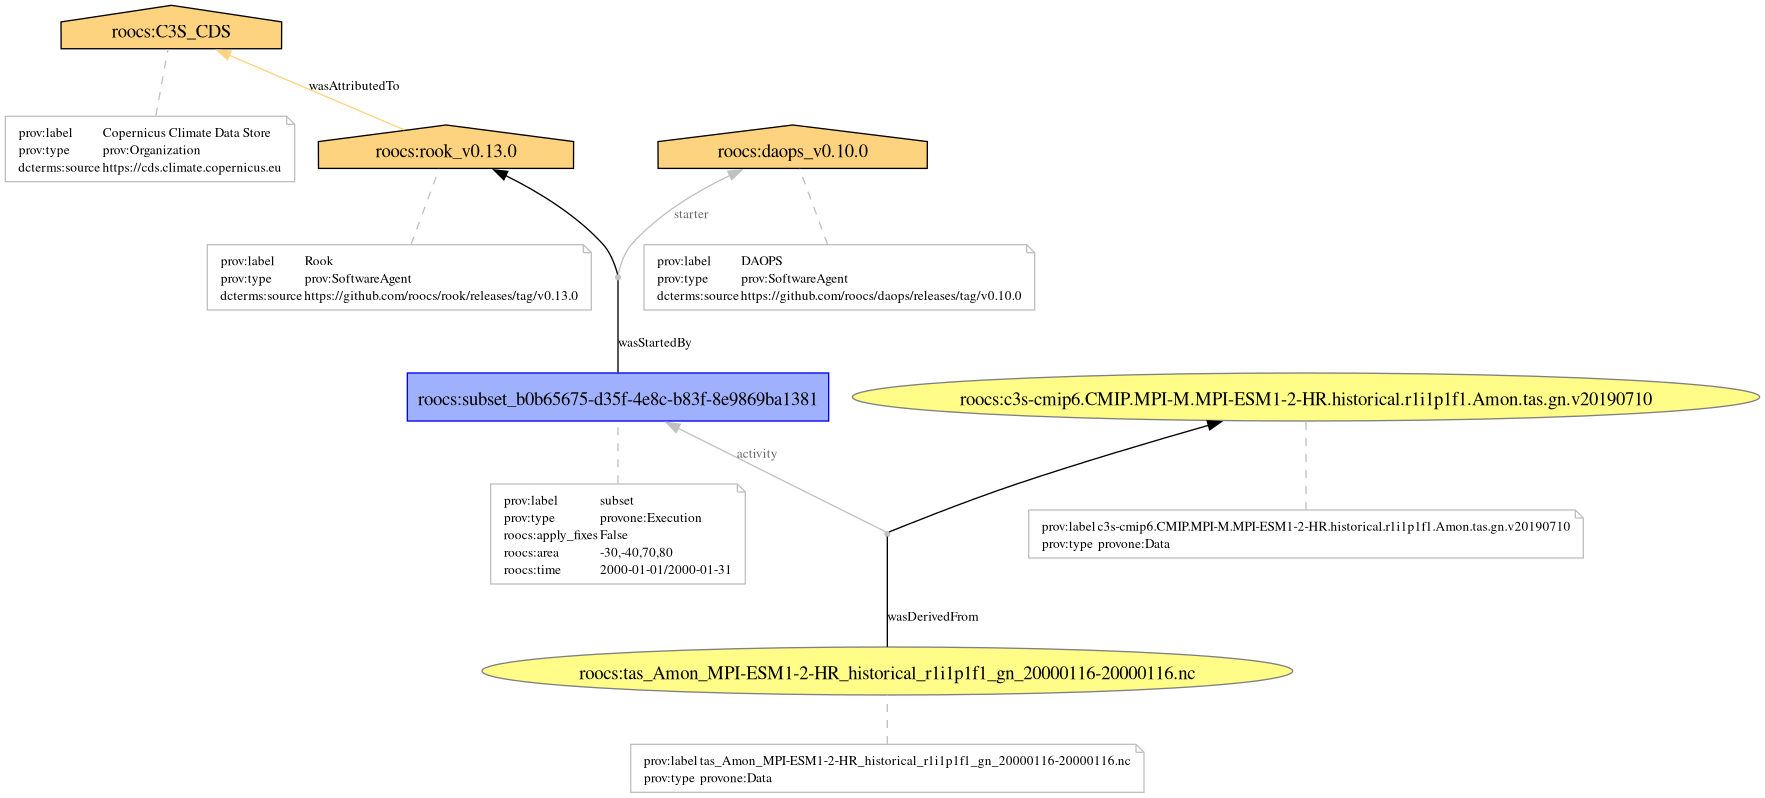

In [5]:
from IPython.display import Image
Image(resp.provenance_image())

## Run workflow with subset and average operator

Instead of running a single operator one can also chain several operators in a workflow.

### Use rooki operators to create a workflow 

In [6]:
from rooki import operators as ops

### Define the workflow 

... internally the workflow tree is a json document

In [7]:
tas = ops.Input(
    'tas', ['c3s-cmip6.CMIP.MPI-M.MPI-ESM1-2-HR.historical.r1i1p1f1.Amon.tas.gn.v20190710']
)

wf = ops.Subset(
    tas, 
    time="2000/2000",
    time_components="month:jan,feb,mar",
    area='-30,-40,70,80',  
)

wf = ops.WeightedAverage(wf)

### Optional: look at the workflow json document

... *only* to give some insight

In [8]:
import json
print(json.dumps(wf._tree(), indent=4))

{
    "inputs": {
        "tas": [
            "c3s-cmip6.CMIP.MPI-M.MPI-ESM1-2-HR.historical.r1i1p1f1.Amon.tas.gn.v20190710"
        ]
    },
    "steps": {
        "subset_tas_1": {
            "run": "subset",
            "in": {
                "collection": "inputs/tas",
                "time": "2000/2000",
                "time_components": "month:jan,feb,mar",
                "area": "-30,-40,70,80"
            }
        },
        "weighted_average_tas_1": {
            "run": "weighted_average",
            "in": {
                "collection": "subset_tas_1/output"
            }
        }
    },
    "outputs": {
        "output": "weighted_average_tas_1/output"
    }
}


### Submit workflow job 

In [9]:
resp = wf.orchestrate()
resp.ok

True

### Open as xarray dataset

In [10]:
ds = resp.datasets()[0]
ds

<xarray.Dataset> Size: 88B
Dimensions:   (bnds: 2, time: 3)
Coordinates:
    height    float64 8B ...
  * time      (time) datetime64[ns] 24B 2000-01-16T12:00:00 ... 2000-03-16T12...
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (bnds) float64 16B ...
    lon_bnds  (bnds) float64 16B ...
    tas       (time) float64 24B ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/af75dd9f-d9c2-4e0e-a294-2bb0d5b740cf

### Plot dataset

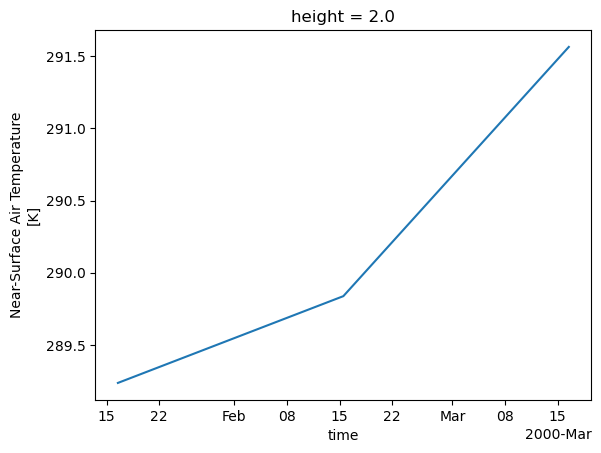

In [11]:
ds.tas.plot()

### Show provenance

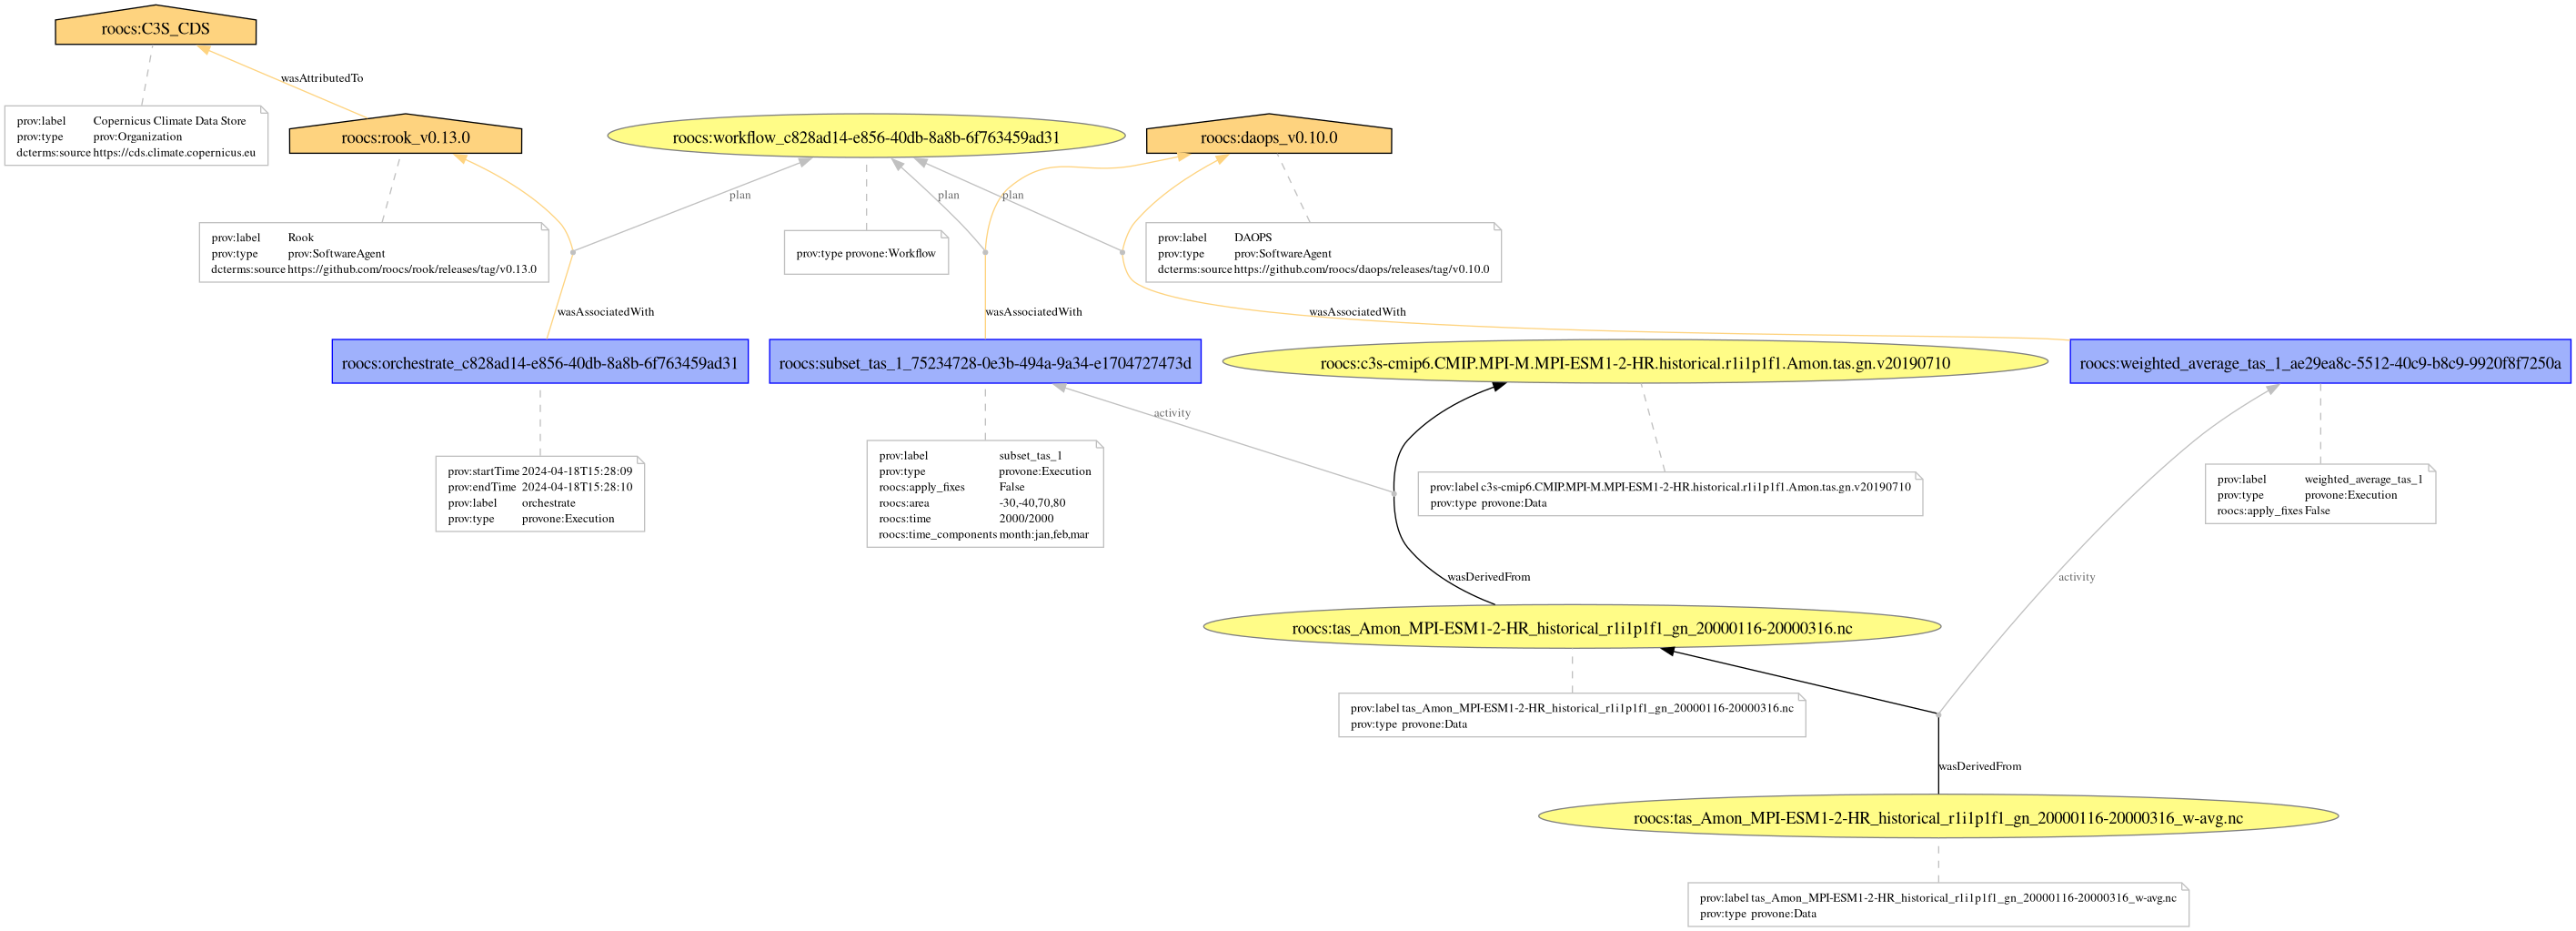

In [12]:
Image(resp.provenance_image())

## Summary
In this notebook, we used the Rooki Python client to retrieve a subset of a CMIP6 dataset. The operations are executed remotely on a Rook subsetting service (using OGC API and xarray/clisops). The dataset is plotted and a provenance document is shown. We also showed that remote operators can be chained to be executed in a single workflow operation.

### What's next?

This service is used by the European Copernicus Climate Data Store. 

We need to figure out how this service can be used in the new ESGF: 
* where will it be deployed? 
* how can it be integrated in the ESGF search (STAC catalogs, ...)
* ???

## Resources and references
- [Roocs on GitHub](https://github.com/roocs)
- [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/)
- [STAC](https://stacspec.org/en)